In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from dataclasses import dataclass

sns.set_theme()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.3

In [2]:
data = pd.read_csv('../data/aapl_5m_train.csv').dropna()

rsi_indicator = ta.momentum.RSIIndicator(close=data['Close'], window=15)
data['rsi'] = rsi_indicator.rsi()

data['buy_signal'] = data['rsi'] < 16
data['sell_signal'] = data['rsi'] > 80

data = data.dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
18,18,1609776000,0,2021-01-04 16:00:00,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False


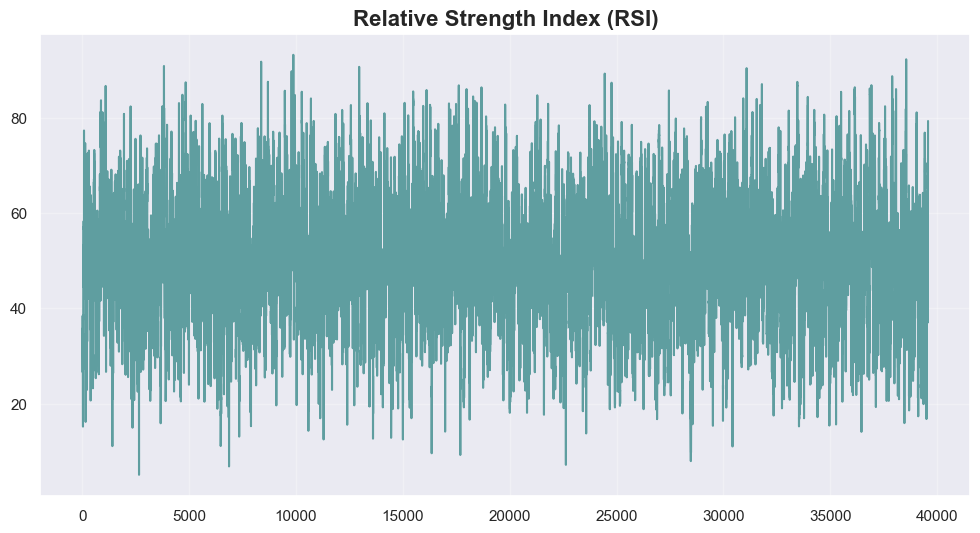

In [3]:
plt.figure()
plt.plot(data['rsi'], label='RSI', color='cadetblue')
plt.title('Relative Strength Index (RSI)')
plt.show()

# Supuestos

+ Comisión = 0.125%
+ No hay impuestos
+ No apalancamiento
+ Cuenta Margen = 50%
+ Capital = 1,000,000
+ N Shares = 50
+ Stop Loss / Take Profit = 6%
+ Trades at Close
+ Borrow Rate 0.25%

In [4]:
COM = 0.125/100

#DOF (Grados de libertad)
STOP_LOSS = 0.10
TAKE_PROFIT = 0.10
N_SHARES = 150

capital = 1_000_000

margin_account = 50/100
BORROW_RATE=0.25/100 #Actual borrow for Apple stock

In [5]:
@dataclass
class Position:
    """
    Represents a trading position.
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [6]:
active_long_positions: list[Position] = []

for i, row in data.iterrows():
    # 1
    # -- LONG ACTIVE ORDERS -- #
    for position in active_long_positions.copy():
        # Stop Loss or take profit Check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1-COM)
            #Remove position from active pos
            active_long_positions.remove(position)

    # 3
    # -- LONG -- #
    # Check Signal
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)
        # Do we have enough capital cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(
                ticker='AAPL',
                n_shares=N_SHARES,
                price=row['Close'],
                sl=row['Close'] * (1 - STOP_LOSS),
                tp=row['Close'] * (1 + TAKE_PROFIT),
                time=row['Datetime']
            )
            active_long_positions.append(pos)
            
#At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions)*N_SHARES * (1-COM)
active_long_positions = []

print(f'Final Capital: {capital:,.2f}')

Final Capital: 1,114,482.66
